In [262]:
%matplotlib inline

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import timeit
from sklearn.ensemble import RandomForestClassifier

In [6]:
# ================================================= #
# Parameter setting
# ================================================= #
# Original data path
data_path = "../TH_data_challenge.tsv"

# Output directory
output_dir = "../output"

In [7]:
# ================================================= #
# Load data
# ================================================= #
df_data = pd.DataFrame.from_csv(data_path, sep='\t', index_col=None)

In [140]:
# ================================================= #
# Process data into numerical features
# ================================================= #
# --- Separate dim_is_requested ("y") from features --- #
df_data_num = df_data.copy(deep=True)
s_dim_is_requested = df_data_num['dim_is_requested']
del df_data_num['dim_is_requested']

# --- Delete some columns --- #
# ds_night, ds, id_listing_anon, id_user_anon - delete
del df_data_num['ds_night']
del df_data_num['ds']
del df_data_num['id_listing_anon']
del df_data_num['id_user_anon']

# --- Fill in missing values --- #
# m_checkouts - 0
df_data_num['m_checkouts'] = df_data_num['m_checkouts'].fillna(0)
# m_reviews - 0
df_data_num['m_reviews'] = df_data_num['m_reviews'].fillna(0)
# days_since_last_booking - a big value (2000)
df_data_num['days_since_last_booking'] = df_data_num['m_reviews'].fillna(2000)
# image_quality_score
df_data_num['image_quality_score'] = \
    df_data_num['image_quality_score'].fillna(
        df_data_num['image_quality_score'].mean())
# m_total_overall_rating - 0
df_data_num['m_total_overall_rating'] = df_data_num['m_total_overall_rating'].fillna(0)
# m_professional_pictures - 0
df_data_num['m_professional_pictures'] = df_data_num['m_professional_pictures'].fillna(0)
# ds_checkin_gap - maximum value (7)
df_data_num['ds_checkin_gap'] = df_data_num['ds_checkin_gap'].fillna(7)
# ds_checkout_gap - maximum value (7)
df_data_num['ds_checkout_gap'] = df_data_num['ds_checkout_gap'].fillna(7)
# occ_occupancy_plus_minus_7_ds_night - calculate from ds_checkin_gap and ds_checkout_gap
df_data_num['occ_occupancy_plus_minus_7_ds_night'] = \
    df_data_num['occ_occupancy_plus_minus_7_ds_night'].fillna(
        1 - (df_data_num['ds_checkin_gap'] + df_data_num['ds_checkout_gap']) / 14)
# occ_occupancy_plus_minus_14_ds_night - calculate from ds_checkin_gap and ds_checkout_gap;
# assuming zero booking for unknown days
df_data_num['occ_occupancy_plus_minus_14_ds_night'] = \
    df_data_num['occ_occupancy_plus_minus_14_ds_night'].fillna(
        1 - (df_data_num['ds_checkin_gap'] + df_data_num['ds_checkout_gap']) / 28)
# occ_occupancy_trailing_90_ds - 0
df_data_num['occ_occupancy_trailing_90_ds'] = \
    df_data_num['occ_occupancy_trailing_90_ds'].fillna(0)
# m_minimum_nights - minimum value (1)
df_data_num['m_minimum_nights'] = df_data_num['m_minimum_nights'].fillna(1)
# m_maximum_nights - maximum value (10000); also set huge number to 10000
df_data_num['m_maximum_nights'] = df_data_num['m_maximum_nights'].fillna(10000)
df_data_num['m_maximum_nights'][df_data_num['m_maximum_nights']>10000] = 10000
# price_booked_most_recent - same as m_effective_daily_price
df_data_num['price_booked_most_recent'] = df_data_num['price_booked_most_recent'].fillna(
    df_data_num['m_effective_daily_price'])
# p2_p3_click_through_score - fill with mean
df_data_num['p2_p3_click_through_score'] = df_data_num['p2_p3_click_through_score'].fillna(
    df_data_num['p2_p3_click_through_score'].mean())
# p3_inquiry_score  - fill with mean
df_data_num['p3_inquiry_score'] = df_data_num['p3_inquiry_score'].fillna(
    df_data_num['p3_inquiry_score'].mean())
# listing_m_listing_views_2_6_ds_night_decay - fill with mean
df_data_num['listing_m_listing_views_2_6_ds_night_decay'] = \
    df_data_num['listing_m_listing_views_2_6_ds_night_decay'].fillna(
        df_data_num['listing_m_listing_views_2_6_ds_night_decay'].mean())
# r_kdt_listing_views_0_6_avg_n100 - fill with mean
df_data_num['r_kdt_listing_views_0_6_avg_n100'] = \
    df_data_num['r_kdt_listing_views_0_6_avg_n100'].fillna(
        df_data_num['r_kdt_listing_views_0_6_avg_n100'].mean())
# r_kdt_n_active_n100 - fill with mean
df_data_num['r_kdt_n_active_n100'] = \
    df_data_num['r_kdt_n_active_n100'].fillna(
        df_data_num['r_kdt_n_active_n100'].mean())
# r_kdt_n_available_n100 - fill with mean
df_data_num['r_kdt_n_available_n100'] = \
    df_data_num['r_kdt_n_available_n100'].fillna(
        df_data_num['r_kdt_n_available_n100'].mean())
# r_kdt_m_effective_daily_price_n100_p50 - fill with mean
df_data_num['r_kdt_m_effective_daily_price_n100_p50'] = \
    df_data_num['r_kdt_m_effective_daily_price_n100_p50'].fillna(
        df_data_num['r_kdt_m_effective_daily_price_n100_p50'].mean())
# r_kdt_m_effective_daily_price_available_n100_p50 - fill with mean
df_data_num['r_kdt_m_effective_daily_price_available_n100_p50'] = \
    df_data_num['r_kdt_m_effective_daily_price_available_n100_p50'].fillna(
        df_data_num['r_kdt_m_effective_daily_price_available_n100_p50'].mean())
# r_kdt_m_effective_daily_price_booked_n100_p50
df_data_num['r_kdt_m_effective_daily_price_booked_n100_p50'] = \
    df_data_num['r_kdt_m_effective_daily_price_booked_n100_p50'].fillna(
        df_data_num['r_kdt_m_effective_daily_price_booked_n100_p50'].mean())
    
# --- Encode categorical features --- #
# --- Put these features separate from the continuous features --- #
list_encoded = []
# dim_market - one-hot encoding
df = encode_column_onehot(
    df_data_num, 'dim_market', ['Los Angeles', 'Paris', 'San Francisco'])
list_encoded.append(df)
# dim_room_type - one-hot encoding
df = encode_column_onehot(
    df_data_num, 'dim_room_type', ['Private room', 'Shared room', 'Entire home/apt'])
list_encoded.append(df)
# dim_is_instant_bookable - boolean -> int
s = df_data_num['dim_is_instant_bookable'].astype(int)
del df_data_num['dim_is_instant_bookable']
list_encoded.append(s)
# cancel_policy - one-hot encoding
df = encode_column_onehot(
    df_data_num, 'cancel_policy', [3, 4, 5, 6, 7, 8, 9])
list_encoded.append(df)
# dim_has_wireless_internet - keep as 0/1
s = df_data_num['dim_has_wireless_internet']
del df_data_num['dim_has_wireless_internet']
list_encoded.append(s)
# ds_night_day_of_week - cyclic encoding
df = encode_column_cyclic(df_data_num, 'ds_night_day_of_week', [0, 7])
list_encoded.append(df)
# ds_night_day_of_year - cyclic encoding
df = encode_column_cyclic(df_data_num, 'ds_night_day_of_year', [0, 365])
list_encoded.append(df)

# --- Standardize continuous features to have zero mean and unit variance --- #
s_feature_mean = df_data_num.mean(axis=0)
s_feature_std = df_data_num.std(axis=0)
df_data_num = (df_data_num - s_feature_mean) / s_feature_std

# --- Put "y", continuous features and encoded categorical features together --- #
df_data_num = pd.concat([s_dim_is_requested] + [df_data_num] + list_encoded, axis=1)

C:\Users\Mao\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


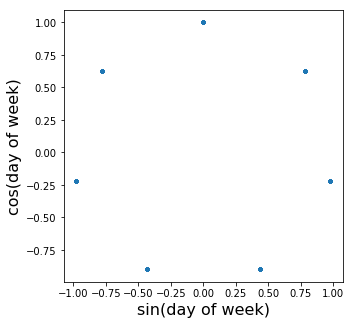

In [9]:
# (plot encoded ds_night_day_of_week for illustration)
fig = plt.figure(figsize=(5, 5))
s_sin = df_data_num['ds_night_day_of_week_1']
s_cos = df_data_num['ds_night_day_of_week_2']
plt.plot(s_sin, s_cos, '.')
plt.xlabel("sin(day of week)", fontsize=16)
plt.ylabel("cos(day of week)", fontsize=16)
plt.axis('scaled');
fig.savefig(os.path.join(output_dir, 'cyclic_encode.png'),
            format='png', bbox_inches='tight')

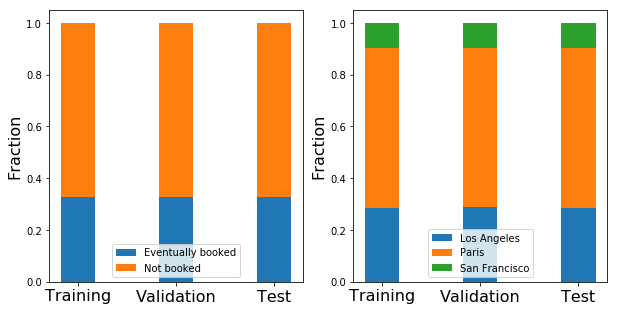

In [147]:
# ================================================= #
# Divide training, validation and test sets (6:2:2)
# ================================================= #
np.random.seed(2222)
# --- Determine the size of each set --- #
n_train = int(len(df_data_num) * 0.6)
n_vali = int(len(df_data_num) * 0.2)
n_test = len(df_data_num) - n_train - n_vali
# --- Randomly divide the orig. dataset --- #
df_shuffled = df_data_num.sample(frac=1)
df_train = df_shuffled[:n_train]
df_vali = df_shuffled[n_train:(n_train+n_vali)]
df_test = df_shuffled[(n_train+n_vali):]

# --- Check whether data is evenly distributed - plot bar charts --- #
fig = plt.figure(figsize=(10, 5))
# Check dim_is_requested distribution
ax = plt.subplot(1, 2, 1)
y_frac_train = df_train['dim_is_requested'].sum() / len(df_train)
y_frac_vali = df_vali['dim_is_requested'].sum() / len(df_vali)
y_frac_test = df_test['dim_is_requested'].sum() / len(df_test)
y_true = [y_frac_train, y_frac_vali, y_frac_test]
y_false = [1-y_frac_train, 1-y_frac_vali, 1-y_frac_test]
ax = plot_bar_stacked(
    ax, [y_true, y_false],
    bar_names=['Training', 'Validation', 'Test'],
    ylabel='Fraction',
    legends=['Eventually booked', 'Not booked'])
# Check dim_market distribution
ax = plt.subplot(1, 2, 2)
market_frac = []
n_market = 3
for i in range(n_market):
    frac_train = df_train['dim_market_{}'.format(i+1)].sum() / len(df_train)
    frac_vali = df_vali['dim_market_{}'.format(i+1)].sum() / len(df_vali)
    frac_test = df_test['dim_market_{}'.format(i+1)].sum() / len(df_test)
    market_frac.append([frac_train, frac_vali, frac_test])
ax = plot_bar_stacked(
    ax, market_frac,
    bar_names=['Training', 'Validation', 'Test'],
    ylabel='Fraction',
    legends=['Los Angeles', 'Paris', 'San Francisco'])
fig.savefig(os.path.join(output_dir, 'data_divide_check.png'),
            format='png', bbox_inches='tight')

In [222]:
# ================================================= #
# Fit logistic regression (all features; no regularization)
# ================================================= #
# Extract data
X_train = df_train.values[:, 1:]
y_train = df_train['dim_is_requested'].astype(int).values
X_vali = df_vali.values[:, 1:]
y_vali = df_vali['dim_is_requested'].astype(int).values
# --- Run model --- #
logreg_no_reg, f1_train_no_reg, f1_vali_no_reg, fitted_coef_no_reg, time_fit_no_reg = \
    run_model_logreg('l2', 1e9, X_train, y_train, X_vali, y_vali)

In [225]:
print('Time for fitting: {} seconds'.format(time_fit_no_reg))
print(f1_train_no_reg, f1_vali_no_reg)
print('Top features: ', find_top_features_logreg(fitted_coef_no_reg, df_data_num, 10), '\n')

Time for fitting: 46.42946608186321 seconds
0.612755836515 0.605361803084
Top features:  ['dim_market_2' 'cancel_policy_5' 'price_booked_most_recent'
 'occ_occupancy_trailing_90_ds'
 'listing_m_listing_views_2_6_ds_night_decay' 'dim_has_wireless_internet'
 'r_kdt_n_active_n100' 'm_total_overall_rating' 'dim_is_instant_bookable'
 'general_market_m_contacts_0_6_ds_night'] 



In [258]:
# ================================================= #
# Learning curve for logistic regression model, no regularization
# ================================================= #
# --- Run the model for various number of training size --- #
results = {}
m_values = [100, 300, 1000, 3000, 10000, 30000, len(X_train)]
for m in m_values:
    print('m = {}'.format(m))
    results[m] = run_model_logreg(
        'l2', 1e9, X_train[:m], y_train[:m], X_vali, y_vali)

m = 100
m = 300
m = 1000
m = 3000
m = 10000
m = 30000
m = 110567


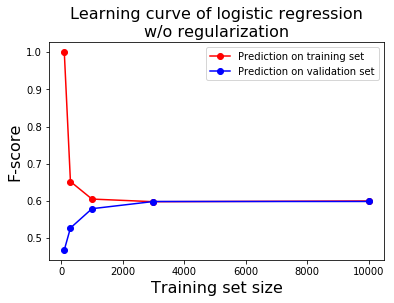

In [261]:
# --- Plot learning curve --- #
fig = plt.figure()
list_f1_train = [results[m][1] for m in m_values]
list_f1_vali = [results[m][2] for m in m_values]
plt.plot(m_values[:5], list_f1_train[:5], 'ro-')
plt.plot(m_values[:5], list_f1_vali[:5], 'bo-')
plt.xlabel('Training set size', fontsize=16)
plt.ylabel('F-score', fontsize=16)
plt.title('Learning curve of logistic regression\nw/o regularization',
          fontsize=16)
plt.legend(['Prediction on training set', 'Prediction on validation set'])
fig.savefig(os.path.join(output_dir, 'learning_curve_logreg.png'),
            format='png', bbox_inches='tight')

In [220]:
# ================================================= #
# Fit logistic regression (all features; L2 regularization)
# ================================================= #
# Extract data
X_train = df_train.values[:, 1:]
y_train = df_train['dim_is_requested'].astype(int).values
X_vali = df_vali.values[:, 1:]
y_vali = df_vali['dim_is_requested'].astype(int).values
# --- Run model with various C values --- #
for C in [100, 30, 10, 3, 1, 0.3]:
    logreg, f1_train, f1_vali, fitted_coef, time_fit = run_model_logreg(
        'l2', C, X_train, y_train, X_vali, y_vali)
    print('L2 regularization, C = {}'.format(C))
    print('Time for fitting: {:.1f} seconds'.format(time_fit))
    print('F1 score for training & validation sets: {:.3f} {:.3f}'.format(
        f1_train, f1_vali))
    print('Top features: ', find_top_features_logreg(fitted_coef, df_data_num, 10), '\n')

L2 regularization, C = 100
Time for fitting: 35.3 seconds
F1 score for training & validation sets: 0.613 0.605
Top features:  ['dim_market_2' 'cancel_policy_5' 'price_booked_most_recent'
 'occ_occupancy_trailing_90_ds'
 'listing_m_listing_views_2_6_ds_night_decay' 'dim_has_wireless_internet'
 'r_kdt_n_active_n100' 'm_total_overall_rating' 'dim_is_instant_bookable'
 'general_market_m_contacts_0_6_ds_night'] 

L2 regularization, C = 30
Time for fitting: 23.0 seconds
F1 score for training & validation sets: 0.612 0.604
Top features:  ['dim_market_2' 'cancel_policy_5' 'price_booked_most_recent'
 'occ_occupancy_trailing_90_ds'
 'listing_m_listing_views_2_6_ds_night_decay' 'dim_has_wireless_internet'
 'r_kdt_n_active_n100' 'm_total_overall_rating' 'dim_is_instant_bookable'
 'general_market_m_contacts_0_6_ds_night'] 

L2 regularization, C = 10
Time for fitting: 17.7 seconds
F1 score for training & validation sets: 0.613 0.604
Top features:  ['dim_market_2' 'cancel_policy_5' 'price_booked_most

In [303]:
# ================================================= #
# Random forest
# ================================================= #
# Run model
n_estimator_values = [3, 10, 30, 100, 300, 1000]
results = {}
for n_estimator in n_estimator_values:
    print('n_estimator = {}'.format(n_estimator))
    results[n_estimator] = run_model_random_forest(
        n_estimator, X_train, y_train, X_vali, y_vali)

n_estimator = 3
n_estimator = 10
n_estimator = 30
n_estimator = 100
n_estimator = 300
n_estimator = 1000


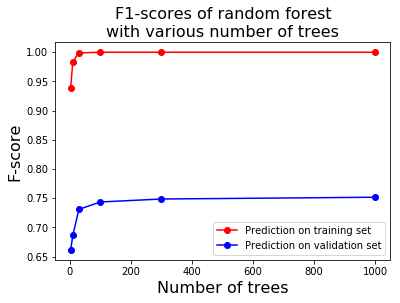

In [315]:
# Extract and plot results
list_f1_train = [results[n_estimator][1] for n_estimator in n_estimator_values]
list_f1_vali = [results[n_estimator][2] for n_estimator in n_estimator_values]
fig = plt.figure()
plt.plot(n_estimator_values, list_f1_train, 'ro-')
plt.plot(n_estimator_values, list_f1_vali, 'bo-')
plt.xlabel('Number of trees', fontsize=16)
plt.ylabel('F-score', fontsize=16)
plt.title('F1-scores of random forest\nwith various number of trees',
          fontsize=16)
plt.legend(['Prediction on training set', 'Prediction on validation set'])
fig.savefig(os.path.join(output_dir, 'random_forest_f1.png'),
            format='png', bbox_inches='tight')

In [316]:
# Print model fitting time
[results[n_estimator][3] for n_estimator in n_estimator_values]

[1.6038045858258556,
 4.6356810997240245,
 14.27768763770655,
 48.03367223529858,
 144.61219302957397,
 470.0623195297849]

In [332]:
# Print top features
find_top_features_random_forest(results[100][0], df_data_num, 20)

[47 46 44 45 38 36 48 34 37 39 35 41 43 25 42 40 50 12 10 11]


array(['cancel_policy_7', 'cancel_policy_6', 'cancel_policy_4',
       'cancel_policy_5', 'dim_room_type_2', 'dim_market_3',
       'dim_has_wireless_internet', 'dim_market_1', 'dim_room_type_1',
       'dim_room_type_3', 'dim_market_2', 'cancel_policy_1',
       'cancel_policy_3', 'general_market_m_is_booked_0_6_ds_night',
       'cancel_policy_2', 'dim_is_instant_bookable',
       'ds_night_day_of_week_2', 'ds_checkout_gap',
       'm_professional_pictures', 'ds_checkin_gap'], dtype=object)

In [337]:
# Prediction on the test set with n_tree = 100
X_test = df_test.values[:, 1:]
y_test = df_test['dim_is_requested'].astype(int).values
y_test_pred = results[100][0].predict(X_test)
f1_test = f1_score(y_true=y_test, y_pred=y_test_pred)
print('Final test F-score = {}'.format(f1_test))

Final test F-score = 0.7467724168319013


# Functions

In [331]:
def find_top_features_random_forest(clf, df, largest_x):
    ''' Find the most influential features (with largest positive coefficients)
    
    Parameters
    ----------
    clf: <sklearn.ensemble.forest.RandomForestClassifier>
        The random forest model object
    df: <pd.DataFrame>
        Original dataframe with the first column being y label
    largest_x: <int>
        The top x parameters with the largest coefficients will be returned
    '''
    
    max_coef_ind = clf.feature_importances_.argsort()[:largest_x]
    print(max_coef_ind)
    top_features = df.columns[1:][max_coef_ind].values
    return top_features

In [307]:
def run_model_random_forest(n_estimators, X_train, y_train, X_vali, y_vali):
    ''' Fit a logistic regression model on the training set and
    predict on training and test set. Calculate F score.
    
    Parameters
    ----------
    n_estimators: <int>
        Number of trees in the forest
    X_train: <np.array>
        Training features
    y_train: <np.array>
        Training labels
    X_vali: <np.array>
        Validation features
    y_vali: <np.array>
        Validation labels
    
    Returns
    ----------
    clf: <sklearn.ensemble.forest.RandomForestClassifier>
        The random forest model object
    f1_train: <floag>
        F1 score on the training set
    f1_vali: <floag>
        F1 score on the validation set
    time_fit: <float>
        Time for fitting in seconds
    '''
    
    # --- Fit model --- #
    clf = RandomForestClassifier(n_estimators=n_estimators)
    time1 = timeit.default_timer()
    clf.fit(X_train, y_train)
    time2 = timeit.default_timer()
    time_fit = time2 - time1
    
    # --- Predict --- #
    y_train_pred = clf.predict(X_train)
    y_vali_pred = clf.predict(X_vali)
    f1_train = f1_score(y_true=y_train, y_pred=y_train_pred)
    f1_vali = f1_score(y_true=y_vali, y_pred=y_vali_pred)
    
    return clf, f1_train, f1_vali, time_fit

In [304]:
def find_top_features_logreg(fitted_coef, df, largest_x):
    ''' Find the most influential features (with largest positive coefficients)
    
    Parameters
    ----------
    fitted_coef: <np.array>
        Fitted coefficients
    df: <pd.DataFrame>
        Original dataframe with the first column being y label
    largest_x: <int>
        The top x parameters with the largest coefficients will be returned
    '''
    
    max_coef_ind = logreg_coef.argsort()[-largest_x:][::-1]
    top_features = df.columns[1:][max_coef_ind].values
    return top_features

In [192]:
def run_model_logreg(penalty, C, X_train, y_train, X_vali, y_vali):
    ''' Fit a logistic regression model on the training set and
    predict on training and test set. Calculate F score.
    
    Parameters
    ----------
    penalty: <string>
        Regularization method. l1 or l2.
    C: <float>
        Regularization parameter. Larger C means less regularization.
    X_train: <np.array>
        Training features
    y_train: <np.array>
        Training labels
    X_vali: <np.array>
        Validation features
    y_vali: <np.array>
        Validation labels
    
    Returns
    ----------
    logreg: <sklearn.linear_model.logistic.>
        The logistic regression model object
    f1_train: <floag>
        F1 score on the training set
    f1_vali: <floag>
        F1 score on the validation set
    fitted_coef: <np.array>
        An array of fitted coefficients
    time_fit: <float>
        Time for fitting in seconds
    '''
    
    # --- Fit model --- #
    logreg = LogisticRegression(penalty=penalty, C=C)
    time1 = timeit.default_timer()
    logreg.fit(X_train, y_train)
    time2 = timeit.default_timer()
    time_fit = time2 - time1
    fitted_coef = logreg.coef_.squeeze()
    
    # --- Predict --- #
    y_train_pred = logreg.predict(X_train)
    y_vali_pred = logreg.predict(X_vali)
    f1_train = f1_score(y_true=y_train, y_pred=y_train_pred)
    f1_vali = f1_score(y_true=y_vali, y_pred=y_vali_pred)
    
    return logreg, f1_train, f1_vali, fitted_coef, time_fit

In [18]:
def plot_bar_stacked(ax, data, bar_names, ylabel, legends):
    ''' Plot a stacked bar plot.
    
    Parameters
    ----------
    ax: <matplotlib.axes._subplots.AxesSubplot>
        Axis to plot
    data: <list>
        Nested data to plot.
        Level 1: each stack; level 2: each bar
    bar_names: <list>
        List of names to show on the x axis; must be the same length
        as the number of bars in data
    ylabel: <str>
        ylabel on the plot
    legends: <list>
        List of legends; must be the same length of number of stacks
    
    Returns
    ----------
    ax: <matplotlib.axes._subplots.AxesSubplot>
        The axis
    '''
    
    width = 0.35
    nbars = len(data[0])
    ind = range(nbars)
    list_p = []
    bottom = data[0]
    bottom = [0 for d in bottom]
    for i, data_bar in enumerate(data):
        list_p.append(plt.bar(ind, data_bar, width,
                              bottom=bottom))
        bottom = [d+data_bar[j] for j, d in enumerate(bottom)]
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(ind, bar_names)
    plt.legend(list_p, legends)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    return ax

In [4]:
def encode_column_cyclic(df, column_name, circle_range):
    ''' Delete a column in a DataFrame and return a list of columns (in a df)
    with cyclic encoded numerical values.
    
    Parameters
    ----------
    df: <pd.DataFrame>
        Original df
    column_name: <str>
        Name of the column to be replaced
    circle_range: <list>
        A list of two numbers indicating the range of the orig. data. These
        two numbers are essentially representing the same point in a circle.
        E.g., if weekdays are represented by 0, 1, ..., 6, then circle_range
        = [0, 7]
    Return
    ----------
    df_cyclic: <pd.DataFrame>
        The new df, with column names "column_name_1", "column_name_2"
    '''

    # Generate cyclically encoded columns
    s_sin = np.sin(2 * np.pi * df_data_num[column_name] / (circle_range[1] - circle_range[0]))
    s_cos = np.cos(2 * np.pi * df_data_num[column_name] / (circle_range[1] - circle_range[0]))
    # Delete the original column
    del df[column_name]
    # Generate new df
    new_column_names = []
    for i in range(2):
        new_column_names.append('{}_{}'.format(column_name, i+1))
    df_cyclic = pd.concat([s_sin, s_cos], axis=1, keys=new_column_names)
    
    return df_cyclic

In [5]:
def encode_column_onehot(df, column_name, list_categ):
    ''' Delete a column in a DataFrame and return a list of columns (in a df)
    with one-hot encoded numerical values.
    
    Parameters
    ----------
    df: <pd.DataFrame>
        Original df
    column_name: <str>
        Name of the column to be replaced
    list_catog: <list>
        List of categories in the column
    
    Return
    ----------
    df_onehot: <pd.DataFrame>
        The new df, with column names "column_name_1", "column_name_2", ...
    '''
    
    # Generate one-hot encoded columns
    list_s = []
    for i in range(len(list_categ)):
        s = (df[column_name] == list_categ[i]).astype(int)
        list_s.append(s)
    # Check if all categories sum up to the total number of data points
    sum_num = sum([sum(s) for s in list_s])
    if sum_num != len(df):
        print('Warming: {} has missing data!'.format(column_name))
    # Delete the original column
    del df[column_name]
    # Generate new df
    new_column_names = []
    for i in range(len(list_categ)):
        new_column_names.append('{}_{}'.format(column_name, i+1))
    df_onehot = pd.concat(list_s, axis=1, keys=new_column_names)
    
    return df_onehot